In [1]:
import pandas as pd
import networkx as nx
from networkx import Graph
import numpy as np
import pickle
from dgl.data.utils import save_graphs
import dgl

ImportError: libnvJitLink.so.12: cannot open shared object file: No such file or directory

## PPI network

In [3]:
genes_groups = pd.read_csv("../data/genes_with_groups.csv", index_col="Unnamed: 0")

In [4]:
genes_groups["gene"] = genes_groups["gene"].str.upper()
genes_groups

,gene,group
0,SOX17,492
1,GM6085,119
2,MRPL15,24
3,GM37144,491
4,LYPLA1,129
...,...,...
16896,MT-ND6,474
16897,MT-TE,265
16898,MT-CYTB,385
16899,MT-TT,43


In [6]:
G = nx.read_edgelist("../data/global_ppi_edgelist.txt")

In [9]:
nodes = list(G.nodes)

In [13]:
genes_groups["in_global"] = genes_groups["gene"].isin(nodes)

In [14]:
genes_groups

,gene,group,in_global
0,SOX17,492,True
1,GM6085,119,False
2,MRPL15,24,True
3,GM37144,491,False
4,LYPLA1,129,True
...,...,...,...
16896,MT-ND6,474,True
16897,MT-TE,265,False
16898,MT-CYTB,385,False
16899,MT-TT,43,False


In [15]:
len(nodes)

15461

In [19]:
np.count_nonzero(genes_groups["in_global"])

11423

In [ ]:
genes_groups_intersected = genes_groups[genes_groups["in_global"]]

In [34]:
genes_groups_intersected

,gene,group,in_global
0,SOX17,492,True
2,MRPL15,24,True
4,LYPLA1,129,True
5,TCEA1,345,True
6,RGS20,71,True
...,...,...,...
16890,MT-ND3,75,True
16892,MT-ND4L,173,True
16893,MT-ND4,405,True
16895,MT-ND5,16,True


In [35]:
genes_groups_intersected.to_csv("../data/genes_with_groups_intersection.csv")

In [37]:
G_intersected = G.subgraph(genes_groups_intersected["gene"])

In [40]:
nx.write_edgelist(G_intersected, "../data/global_ppi_edgelist_intersection.txt", data = False)

## Metagraph

In [156]:
from networkx import Graph
from scipy.spatial import cKDTree
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

In [157]:
group_centroids = pd.read_csv("../data/SGR_group_centroids.csv")
group_centroids["centroid"] = group_centroids["centroid"].str.replace("\d(\s+)",",", regex=True).apply(eval)
group_centroids["centroid"] = group_centroids["centroid"].apply(lambda x: np.array(x))

In [158]:
group_centroids["centroid"]

0      [-1.9200074, -1.0824681, 0.8610968, -0.9003772...
1      [3.4196853, 3.4444185, -3.2811885, -0.3687318,...
2      [-4.5388612, -4.3227062, 4.1785678, 3.1901998,...
3      [0.74817, 0.3419735, -0.5120746, -2.742397, -0...
4      [1.7597457, 3.4490149, -0.7080047, 3.0651197, ...
                             ...                        
456    [1.4692729, -0.6397169, 0.6526312, -1.77385, 1...
457    [-2.9538364, -2.6035362, 2.4682561, 0.4326935,...
458    [-1.1811919, -1.8606395, 1.8010016, -0.8689333...
459    [2.3493991, 1.9434537, -2.1954353, -2.0123941,...
460    [-0.935408, -1.5302323, 1.4527914, -1.2469775,...
Name: centroid, Length: 461, dtype: object

In [159]:
group_centroids_dict = dict(zip(group_centroids["label"], group_centroids["centroid"]))
group_centroids_dict

{0: array([-1.9200074 , -1.0824681 ,  0.8610968 , -0.9003772 , -0.23905   ,
         3.6678731 , -1.5414826 , -1.0125209 ,  2.0182245 ,  1.692493  ,
         1.2151557 , -1.1774814 ,  0.1328136 , -2.313154  , -0.8680434 ,
        -2.1846677 ,  1.9333183 ,  0.1189249 , -1.4375804 ,  1.6776557 ,
        -1.300184  ,  1.5718952 ,  1.5924419 , -1.0163389 ,  0.389274  ,
         2.0272371 , -1.611933  ,  0.965715  , -1.8298085 ,  2.1138713 ,
         3.1355733 , -3.29819819]),
 1: array([ 3.4196853,  3.4444185, -3.2811885, -0.3687318,  1.0051468,
        -1.8952567,  3.6571087,  2.8637017, -3.1976764, -3.6286154,
        -2.5567873,  1.4328193, -0.3273814,  1.025808 ,  3.1562414,
         1.7085996, -3.5852658, -2.8645219,  1.8980008, -3.4621124,
         3.295569 , -2.673958 , -2.4258124,  2.3320173,  1.4870528,
        -2.500365 ,  3.3134296, -2.6362   ,  3.620955 , -1.7014984,
        -2.2845313,  3.510589 ]),
 2: array([-4.5388612 , -4.3227062 ,  4.1785678 ,  3.1901998 ,  3.5953373 ,
  

In [160]:
label_to_index_mapping = dict(zip(group_centroids["label"], group_centroids.index))
label_to_index_mapping

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 23: 21,
 24: 22,
 25: 23,
 27: 24,
 28: 25,
 29: 26,
 30: 27,
 31: 28,
 32: 29,
 33: 30,
 35: 31,
 36: 32,
 37: 33,
 38: 34,
 39: 35,
 40: 36,
 41: 37,
 42: 38,
 43: 39,
 44: 40,
 45: 41,
 46: 42,
 47: 43,
 49: 44,
 50: 45,
 51: 46,
 52: 47,
 53: 48,
 54: 49,
 55: 50,
 56: 51,
 57: 52,
 58: 53,
 59: 54,
 62: 55,
 63: 56,
 64: 57,
 65: 58,
 66: 59,
 67: 60,
 68: 61,
 69: 62,
 71: 63,
 72: 64,
 73: 65,
 74: 66,
 75: 67,
 76: 68,
 77: 69,
 78: 70,
 79: 71,
 80: 72,
 81: 73,
 82: 74,
 83: 75,
 84: 76,
 85: 77,
 86: 78,
 87: 79,
 88: 80,
 89: 81,
 90: 82,
 91: 83,
 92: 84,
 93: 85,
 95: 86,
 96: 87,
 98: 88,
 99: 89,
 100: 90,
 101: 91,
 102: 92,
 103: 93,
 104: 94,
 105: 95,
 106: 96,
 107: 97,
 108: 98,
 109: 99,
 110: 100,
 111: 101,
 112: 102,
 114: 103,
 115: 104,
 116: 105,
 117: 106,
 118: 107,
 119: 108,
 122: 109,


In [161]:
centroids_stacked = np.stack(group_centroids["centroid"])
centroids_stacked.shape

(461, 32)

In [162]:
centroids_pairdists = pairwise_distances(centroids_stacked, metric="cosine")

In [163]:
centroids_pairdists.shape

(461, 461)

(array([11005.,  6166.,  5406.,  4828.,  4644.,  4346.,  4170.,  4224.,
         4100.,  4084.,  4242.,  4304.,  4214.,  4222.,  4080.,  3892.,
         3962.,  4210.,  4106.,  4014.,  4072.,  4044.,  4116.,  4052.,
         4086.,  4348.,  4384.,  4456.,  4636.,  4604.,  4438.,  4372.,
         3958.,  4110.,  4042.,  3844.,  3832.,  3820.,  3832.,  3634.,
         3684.,  3566.,  3428.,  3346.,  3670.,  3754.,  4620.,  4122.,
         3476.,  1956.]),
 array([0.        , 0.03848099, 0.07696198, 0.11544297, 0.15392396,
        0.19240495, 0.23088594, 0.26936693, 0.30784792, 0.34632891,
        0.3848099 , 0.42329089, 0.46177187, 0.50025286, 0.53873385,
        0.57721484, 0.61569583, 0.65417682, 0.69265781, 0.7311388 ,
        0.76961979, 0.80810078, 0.84658177, 0.88506276, 0.92354375,
        0.96202474, 1.00050573, 1.03898672, 1.07746771, 1.1159487 ,
        1.15442969, 1.19291068, 1.23139167, 1.26987266, 1.30835364,
        1.34683463, 1.38531562, 1.42379661, 1.4622776 , 1.50075859

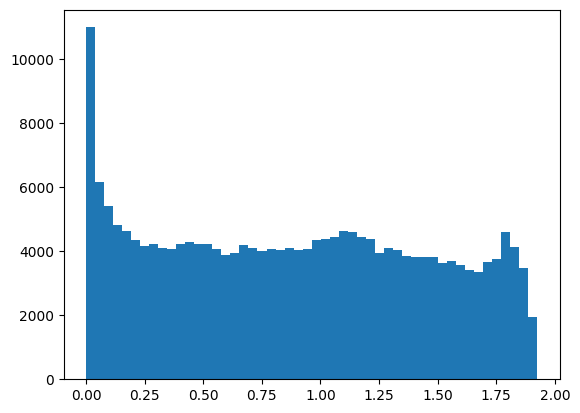

In [164]:
plt.hist(centroids_pairdists.flatten(), bins = 50)

In [165]:
print("1st percentile: ", np.percentile(centroids_pairdists.flatten(), 1))
print("5th percentile: ", np.percentile(centroids_pairdists.flatten(), 5))
print("10th percentile: ", np.percentile(centroids_pairdists.flatten(), 10))
print("25th percentile: ", np.percentile(centroids_pairdists.flatten(), 25))
print("50th percentile: ", np.percentile(centroids_pairdists.flatten(), 50))

1st percentile:  0.001873337949899745
5th percentile:  0.03636274323337285
10th percentile:  0.10595888390727182
25th percentile:  0.3861807290897221
50th percentile:  0.8829702870526656


In [166]:
for i in [1, 5, 10, 25, 40, 50]:
    points = list(group_centroids_dict.keys())
    percentile = i
    dist = np.percentile(centroids_pairdists.flatten(), percentile)

    G = Graph()
    G.add_nodes_from(points)
    G.add_edges_from([(point1, point2)
                    for point1 in points
                    for point2 in points
                    if (centroids_pairdists[label_to_index_mapping[point1], label_to_index_mapping[point2]] <= dist)])
    nx.write_edgelist(G, f"../data/metagraph_{i}%sparsity.txt", data = False)

## Membership edges

In [167]:
# sparsity = 10
# G_genes = nx.read_edgelist("../data/global_ppi_edgelist_intersection.txt")
# G_groups = nx.read_edgelist(f"../data/metagraph_{sparsity}%sparsity.txt")

In [168]:
genes_groups = pd.read_csv("../data/genes_with_groups_intersection.csv", index_col="Unnamed: 0")
genes_groups["gene"] = genes_groups["gene"].str.upper()
genes_groups

,gene,group,in_global
0,SOX17,492,True
2,MRPL15,24,True
4,LYPLA1,129,True
5,TCEA1,345,True
6,RGS20,71,True
...,...,...,...
16890,MT-ND3,75,True
16892,MT-ND4L,173,True
16893,MT-ND4,405,True
16895,MT-ND5,16,True


In [31]:
G_membership = Graph()
G_membership.add_nodes_from(list(set(genes_groups["gene"])) + list(set(genes_groups["group"])))
G_membership.add_edges_from(list(zip(list(genes_groups["gene"]), list(genes_groups["group"]))))


In [ ]:
nx.write_edgelist(G_membership, f"../data/membership_edgelist.txt", data = False)

## Generate DGL graph

In [ ]:
import dgl

In [ ]:
genes_groups = pd.read_csv("../data/genes_with_groups_intersection.csv", index_col="Unnamed: 0")
genes_groups["gene"] = genes_groups["gene"].str.upper()

In [ ]:
group_centroids = pd.read_csv("../data/SGR_group_centroids.csv")


In [ ]:
unique_groups = [int(x) for x in np.unique(group_centroids["label"])]

genes_to_ints = dict(zip(np.unique(genes_groups["gene"]),range(len(np.unique(genes_groups["gene"])))))
ints_to_genes = dict(zip(range(len(np.unique(genes_groups["gene"]))), np.unique(genes_groups["gene"])))
contexts_to_ints = dict(zip(unique_groups,range(len(unique_groups))))
ints_to_contexts = dict(zip(range(len(unique_groups)), unique_groups))

In [ ]:
with open('../data/map_genes_to_ints.pkl', 'wb') as f:
    pickle.dump(genes_to_ints, f)
with open('../data/map_ints_to_genes.pkl', 'wb') as f:
    pickle.dump(ints_to_genes, f)
with open('../data/map_contexts_to_ints.pkl', 'wb') as f:
    pickle.dump(contexts_to_ints, f)
with open('../data/map_ints_to_contexts.pkl', 'wb') as f:
    pickle.dump(ints_to_contexts, f)

In [2]:
# sparsity = 10
# G_genes = nx.read_edgelist("../data/global_ppi_edgelist_intersection.txt")
# G_groups = nx.read_edgelist(f"../data/metagraph_{10}%sparsity.txt")
# G_membership = nx.read_edgelist("../data/membership_edgelist.txt")

In [181]:
sparsity = 10
gene_edges = pd.read_csv("../data/global_ppi_edgelist_intersection.txt", sep=" ", header=None)
# gene_edges = gene_edges[gene_edges[0] != gene_edges[1]]
context_edges = pd.read_csv(f"../data/metagraph_{sparsity}%sparsity.txt", sep=" ", header=None)
membership_edges = pd.read_csv("../data/membership_edgelist.txt", sep=" ", header=None)

gene_edges["gene0int"] = gene_edges[0].apply(lambda x: genes_to_ints[x])
gene_edges["gene1int"] = gene_edges[1].apply(lambda x: genes_to_ints[x])
context_edges["context0int"] = context_edges[0].apply(lambda x: contexts_to_ints[x])
context_edges["context1int"] = context_edges[1].apply(lambda x: contexts_to_ints[x])
membership_edges["geneint"] = membership_edges[0].apply(lambda x: genes_to_ints[x])
membership_edges["contextint"] = membership_edges[1].apply(lambda x: contexts_to_ints[x])



In [182]:
graph_data = {("gene", "ispartof", "spatialcontext"): (membership_edges["geneint"], membership_edges["contextint"]),
              ("gene", "interactswith", "gene"): (gene_edges["gene0int"], gene_edges["gene1int"]),
              ("spatialcontext", "issimilarto", "spatialcontext"): (context_edges["context0int"], context_edges["context1int"])}


In [186]:
hg = dgl.heterograph(graph_data)

In [187]:
hg = dgl.add_reverse_edges(hg, copy_ndata=True,
                           copy_edata=True,ignore_bipartite=True)

In [188]:
hg

Graph(num_nodes={'gene': 11423, 'spatialcontext': 461},
      num_edges={('gene', 'interactswith', 'gene'): 298057, ('gene', 'ispartof', 'spatialcontext'): 11423, ('spatialcontext', 'issimilarto', 'spatialcontext'): 21253},
      metagraph=[('gene', 'gene', 'interactswith'), ('gene', 'spatialcontext', 'ispartof'), ('spatialcontext', 'spatialcontext', 'issimilarto')])

In [ ]:
dgl.save_graphs(f"../data/FULL_HETERO_GRAPH_{sparsity}%sparsity.bin", [hg], labels=None)

In [199]:
hg = dgl.load_graphs(f"../data/FULL_HETERO_GRAPH_{sparsity}%sparsity.bin")[0][0]

In [200]:
hg

Graph(num_nodes={'gene': 11423, 'spatialcontext': 461},
      num_edges={('gene', 'interactswith', 'gene'): 298057, ('gene', 'ispartof', 'spatialcontext'): 11423, ('spatialcontext', 'issimilarto', 'spatialcontext'): 21253},
      metagraph=[('gene', 'gene', 'interactswith'), ('gene', 'spatialcontext', 'ispartof'), ('spatialcontext', 'spatialcontext', 'issimilarto')])

In [ ]:
## Looped version:

for sparsity in [1, 10, 40]:
    gene_edges = pd.read_csv("../data/global_ppi_edgelist_intersection.txt", sep=" ", header=None)
    # gene_edges = gene_edges[gene_edges[0] != gene_edges[1]]
    context_edges = pd.read_csv(f"../data/metagraph_{sparsity}%sparsity.txt", sep=" ", header=None)
    membership_edges = pd.read_csv("../data/membership_edgelist.txt", sep=" ", header=None)

    gene_edges["gene0int"] = gene_edges[0].apply(lambda x: genes_to_ints[x])
    gene_edges["gene1int"] = gene_edges[1].apply(lambda x: genes_to_ints[x])
    context_edges["context0int"] = context_edges[0].apply(lambda x: contexts_to_ints[x])
    context_edges["context1int"] = context_edges[1].apply(lambda x: contexts_to_ints[x])
    membership_edges["geneint"] = membership_edges[0].apply(lambda x: genes_to_ints[x])
    membership_edges["contextint"] = membership_edges[1].apply(lambda x: contexts_to_ints[x])
    
    graph_data = {("gene", "ispartof", "spatialcontext"): (membership_edges["geneint"], membership_edges["contextint"]),
              ("gene", "interactswith", "gene"): (gene_edges["gene0int"], gene_edges["gene1int"]),
              ("spatialcontext", "issimilarto", "spatialcontext"): (context_edges["context0int"], context_edges["context1int"])}

    hg = dgl.heterograph(graph_data)
    hg = dgl.add_reverse_edges(hg, copy_ndata=True, copy_edata=True,ignore_bipartite=True)
    dgl.save_graphs(f"../data/FULL_HETERO_GRAPH_BIDIRECTIONAL_{sparsity}%sparsity.bin", [hg], labels=None)

## DGL test

In [3]:
import itertools
import os

os.environ["DGLBACKEND"] = "pytorch"

import dgl
import dgl.data
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
sparsity = 10
g = dgl.load_graphs(f"/n/data1/hms/dbmi/zitnik/lab/users/kel331/spatialGNN/data/FULL_HETERO_GRAPH_{sparsity}%sparsity.bin")[0][0]

In [3]:
g

Graph(num_nodes={'gene': 11423, 'spatialcontext': 461},
      num_edges={('gene', 'interactswith', 'gene'): 298057, ('gene', 'ispartof', 'spatialcontext'): 11423, ('spatialcontext', 'issimilarto', 'spatialcontext'): 21253},
      metagraph=[('gene', 'gene', 'interactswith'), ('gene', 'spatialcontext', 'ispartof'), ('spatialcontext', 'spatialcontext', 'issimilarto')])

## Visualization

In [37]:
from collections import defaultdict
from collections.abc import Mapping

import networkx as nx
import numpy as np
from scipy.sparse import spmatrix

from dgl import backend as F, graph_index, heterograph_index, utils
from dgl.base import DGLError, EID, ETYPE, NID, NTYPE
from dgl.heterograph import combine_frames, DGLBlock, DGLGraph


In [53]:
"""Module for converting graph from/to other object."""

__all__ = [
    "graph",
    "hetero_from_shared_memory",
    "heterograph",
    "create_block",
    "block_to_graph",
    "to_heterogeneous",
    "to_homogeneous",
    "from_scipy",
    "bipartite_from_scipy",
    "from_networkx",
    "bipartite_from_networkx",
    "to_networkx",
    "from_cugraph",
    "to_cugraph",
]


def graph(
    data,
    *,
    num_nodes=None,
    idtype=None,
    device=None,
    row_sorted=False,
    col_sorted=False,
):
    """Create a graph and return.

    Parameters
    ----------
    data : graph data
        The data for constructing a graph, which takes the form of :math:`(U, V)`.
        :math:`(U[i], V[i])` forms the edge with ID :math:`i` in the graph.
        The allowed data formats are:

        - ``(Tensor, Tensor)``: Each tensor must be a 1D tensor containing node IDs.
          DGL calls this format "tuple of node-tensors". The tensors should have the same
          data type of int32/int64 and device context (see below the descriptions of
          :attr:`idtype` and :attr:`device`).
        - ``('coo', (Tensor, Tensor))``: Same as ``(Tensor, Tensor)``.
        - ``('csr', (Tensor, Tensor, Tensor))``: The three tensors form the CSR representation
          of the graph's adjacency matrix.  The first one is the row index pointer.  The
          second one is the column indices.  The third one is the edge IDs, which can be empty
          to represent consecutive integer IDs starting from 0.
        - ``('csc', (Tensor, Tensor, Tensor))``: The three tensors form the CSC representation
          of the graph's adjacency matrix.  The first one is the column index pointer.  The
          second one is the row indices.  The third one is the edge IDs, which can be empty
          to represent consecutive integer IDs starting from 0.

        The tensors can be replaced with any iterable of integers (e.g. list, tuple,
        numpy.ndarray).
    num_nodes : int, optional
        The number of nodes in the graph. If not given, this will be the largest node ID
        plus 1 from the :attr:`data` argument. If given and the value is no greater than
        the largest node ID from the :attr:`data` argument, DGL will raise an error.
    idtype : int32 or int64, optional
        The data type for storing the structure-related graph information such as node and
        edge IDs. It should be a framework-specific data type object (e.g., ``torch.int32``).
        If ``None`` (default), DGL infers the ID type from the :attr:`data` argument.
        See "Notes" for more details.
    device : device context, optional
        The device of the returned graph, which should be a framework-specific device object
        (e.g., ``torch.device``). If ``None`` (default), DGL uses the device of the tensors of
        the :attr:`data` argument. If :attr:`data` is not a tuple of node-tensors, the
        returned graph is on CPU.  If the specified :attr:`device` differs from that of the
        provided tensors, it casts the given tensors to the specified device first.
    row_sorted : bool, optional
        Whether or not the rows of the COO are in ascending order.
    col_sorted : bool, optional
        Whether or not the columns of the COO are in ascending order within
        each row. This only has an effect when ``row_sorted`` is True.

    Returns
    -------
    DGLGraph
        The created graph.

    Notes
    -----
    1. If the :attr:`idtype` argument is not given then:

       - in the case of the tuple of node-tensor format, DGL uses the
         data type of the given ID tensors.
       - in the case of the tuple of sequence format, DGL uses int64.

       Once the graph has been created, you can change the data type by using
       :func:`dgl.DGLGraph.long` or :func:`dgl.DGLGraph.int`.

       If the specified :attr:`idtype` argument differs from the data type of the provided
       tensors, it casts the given tensors to the specified data type first.
    2. The most efficient construction approach is to provide a tuple of node tensors without
       specifying :attr:`idtype` and :attr:`device`. This is because the returned graph shares
       the storage with the input node-tensors in this case.
    3. DGL internally maintains multiple copies of the graph structure in different
       `sparse formats <https://en.wikipedia.org/wiki/Sparse_matrix>`_ and chooses the most
       efficient one depending on the computation invoked. If memory usage becomes an issue
       in the case of large graphs, use :func:`dgl.DGLGraph.formats` to restrict the allowed
       formats.

    Examples
    --------

    The following example uses PyTorch backend.

    >>> import dgl
    >>> import torch

    Create a small three-edge graph.

    >>> # Source nodes for edges (2, 1), (3, 2), (4, 3)
    >>> src_ids = torch.tensor([2, 3, 4])
    >>> # Destination nodes for edges (2, 1), (3, 2), (4, 3)
    >>> dst_ids = torch.tensor([1, 2, 3])
    >>> g = dgl.graph((src_ids, dst_ids))

    Explicitly specify the number of nodes in the graph.

    >>> g = dgl.graph((src_ids, dst_ids), num_nodes=100)

    Create a graph on the first GPU with data type int32.

    >>> g = dgl.graph((src_ids, dst_ids), idtype=torch.int32, device='cuda:0')

    Creating a graph with CSR representation:

    >>> g = dgl.graph(('csr', ([0, 0, 0, 1, 2, 3], [1, 2, 3], [])))

    Create the same graph with CSR representation and edge IDs.

    >>> g = dgl.graph(('csr', ([0, 0, 0, 1, 2, 3], [1, 2, 3], [0, 1, 2])))

    See Also
    --------
    from_scipy
    from_networkx
    """
    if isinstance(data, spmatrix):
        raise DGLError(
            "dgl.graph no longer supports graph construction from a SciPy "
            "sparse matrix, use dgl.from_scipy instead."
        )

    if isinstance(data, nx.Graph):
        raise DGLError(
            "dgl.graph no longer supports graph construction from a NetworkX "
            "graph, use dgl.from_networkx instead."
        )

    (sparse_fmt, arrays), urange, vrange = utils.graphdata2tensors(data, idtype)
    if num_nodes is not None:  # override the number of nodes
        if num_nodes < max(urange, vrange):
            raise DGLError(
                "The num_nodes argument must be larger than the max ID in the data,"
                " but got {} and {}.".format(num_nodes, max(urange, vrange) - 1)
            )
        urange, vrange = num_nodes, num_nodes

    g = create_from_edges(
        sparse_fmt,
        arrays,
        "_N",
        "_E",
        "_N",
        urange,
        vrange,
        row_sorted=row_sorted,
        col_sorted=col_sorted,
    )

    return g.to(device)


def hetero_from_shared_memory(name):
    """Create a heterograph from shared memory with the given name.

    The newly created graph will have the same node types and edge types as the original graph.
    But it does not have node features or edges features.

    Paramaters
    ----------
    name : str
        The name of the share memory

    Returns
    -------
    HeteroGraph (in shared memory)
    """
    g, ntypes, etypes = heterograph_index.create_heterograph_from_shared_memory(
        name
    )
    return DGLGraph(g, ntypes, etypes)


def heterograph(data_dict, num_nodes_dict=None, idtype=None, device=None):
    """Create a heterogeneous graph and return.

    Parameters
    ----------
    data_dict : graph data
        The dictionary data for constructing a heterogeneous graph. The keys are in the form of
        string triplets (src_type, edge_type, dst_type), specifying the source node,
        edge, and destination node types. The values are graph data in the form of
        :math:`(U, V)`, where :math:`(U[i], V[i])` forms the edge with ID :math:`i`.
        The allowed graph data formats are:

        - ``(Tensor, Tensor)``: Each tensor must be a 1D tensor containing node IDs. DGL calls
          this format "tuple of node-tensors". The tensors should have the same data type,
          which must be either int32 or int64. They should also have the same device context
          (see below the descriptions of :attr:`idtype` and :attr:`device`).
        - ``('coo', (Tensor, Tensor))``: Same as ``(Tensor, Tensor)``.
        - ``('csr', (Tensor, Tensor, Tensor))``: The three tensors form the CSR representation
          of the graph's adjacency matrix.  The first one is the row index pointer.  The
          second one is the column indices.  The third one is the edge IDs, which can be empty
          (i.e. with 0 elements) to represent consecutive integer IDs starting from 0.
        - ``('csc', (Tensor, Tensor, Tensor))``: The three tensors form the CSC representation
          of the graph's adjacency matrix.  The first one is the column index pointer.  The
          second one is the row indices.  The third one is the edge IDs, which can be empty
          to represent consecutive integer IDs starting from 0.

        The tensors can be replaced with any iterable of integers (e.g. list, tuple,
        numpy.ndarray).
    num_nodes_dict : dict[str, int], optional
        The number of nodes for some node types, which is a dictionary mapping a node type
        :math:`T` to the number of :math:`T`-typed nodes. If not given for a node type
        :math:`T`, DGL finds the largest ID appearing in *every* graph data whose source
        or destination node type is :math:`T`, and sets the number of nodes to be that ID
        plus one. If given and the value is no greater than the largest ID for some node type,
        DGL will raise an error. By default, DGL infers the number of nodes for all node types.
    idtype : int32 or int64, optional
        The data type for storing the structure-related graph information such as node and
        edge IDs. It should be a framework-specific data type object (e.g., ``torch.int32``).
        If ``None`` (default), DGL infers the ID type from the :attr:`data_dict` argument.
    device : device context, optional
        The device of the returned graph, which should be a framework-specific device object
        (e.g., ``torch.device``). If ``None`` (default), DGL uses the device of the tensors of
        the :attr:`data` argument. If :attr:`data` is not a tuple of node-tensors, the
        returned graph is on CPU.  If the specified :attr:`device` differs from that of the
        provided tensors, it casts the given tensors to the specified device first.

    Returns
    -------
    DGLGraph
        The created graph.

    Notes
    -----
    1. If the :attr:`idtype` argument is not given then:

       - in the case of the tuple of node-tensor format, DGL uses
         the data type of the given ID tensors.
       - in the case of the tuple of sequence format, DGL uses int64.

       Once the graph has been created, you can change the data type by using
       :func:`dgl.DGLGraph.long` or :func:`dgl.DGLGraph.int`.

       If the specified :attr:`idtype` argument differs from the data type of the provided
       tensors, it casts the given tensors to the specified data type first.
    2. The most efficient construction approach is to provide a tuple of node tensors without
       specifying :attr:`idtype` and :attr:`device`. This is because the returned graph shares
       the storage with the input node-tensors in this case.
    3. DGL internally maintains multiple copies of the graph structure in different sparse
       formats and chooses the most efficient one depending on the computation invoked.
       If memory usage becomes an issue in the case of large graphs, use
       :func:`dgl.DGLGraph.formats` to restrict the allowed formats.
    4. DGL internally decides a deterministic order for the same set of node types and canonical
       edge types, which does not necessarily follow the order in :attr:`data_dict`.

    Examples
    --------

    The following example uses PyTorch backend.

    >>> import dgl
    >>> import torch

    Create a heterograph with three canonical edge types.

    >>> data_dict = {
    ...     ('user', 'follows', 'user'): (torch.tensor([0, 1]), torch.tensor([1, 2])),
    ...     ('user', 'follows', 'topic'): (torch.tensor([1, 1]), torch.tensor([1, 2])),
    ...     ('user', 'plays', 'game'): (torch.tensor([0, 3]), torch.tensor([3, 4]))
    ... }
    >>> g = dgl.heterograph(data_dict)
    >>> g
    Graph(num_nodes={'game': 5, 'topic': 3, 'user': 4},
          num_edges={('user', 'follows', 'topic'): 2, ('user', 'follows', 'user'): 2,
                     ('user', 'plays', 'game'): 2},
          metagraph=[('user', 'topic', 'follows'), ('user', 'user', 'follows'),
                     ('user', 'game', 'plays')])

    Explicitly specify the number of nodes for each node type in the graph.

    >>> num_nodes_dict = {'user': 4, 'topic': 4, 'game': 6}
    >>> g = dgl.heterograph(data_dict, num_nodes_dict=num_nodes_dict)

    Create a graph on the first GPU with data type int32.

    >>> g = dgl.heterograph(data_dict, idtype=torch.int32, device='cuda:0')
    """
    # Convert all data to node tensors first
    node_tensor_dict = {}
    need_infer = num_nodes_dict is None
    if num_nodes_dict is None:
        num_nodes_dict = defaultdict(int)
    for (sty, ety, dty), data in data_dict.items():
        if isinstance(data, spmatrix):
            raise DGLError(
                "dgl.heterograph no longer supports graph construction from a SciPy "
                "sparse matrix, use dgl.from_scipy instead."
            )

        if isinstance(data, nx.Graph):
            raise DGLError(
                "dgl.heterograph no longer supports graph construction from a NetworkX "
                "graph, use dgl.from_networkx instead."
            )
        is_bipartite = sty != dty
        (sparse_fmt, arrays), urange, vrange = utils.graphdata2tensors(
            data, idtype, bipartite=is_bipartite
        )
        node_tensor_dict[(sty, ety, dty)] = (sparse_fmt, arrays)
        if need_infer:
            num_nodes_dict[sty] = max(num_nodes_dict[sty], urange)
            num_nodes_dict[dty] = max(num_nodes_dict[dty], vrange)
        else:  # sanity check
            if num_nodes_dict[sty] < urange:
                raise DGLError(
                    "The given number of nodes of node type {} must be larger than"
                    " the max ID in the data, but got {} and {}.".format(
                        sty, num_nodes_dict[sty], urange - 1
                    )
                )
            if num_nodes_dict[dty] < vrange:
                raise DGLError(
                    "The given number of nodes of node type {} must be larger than"
                    " the max ID in the data, but got {} and {}.".format(
                        dty, num_nodes_dict[dty], vrange - 1
                    )
                )
    # Create the graph
    (
        metagraph,
        ntypes,
        etypes,
        relations,
    ) = heterograph_index.create_metagraph_index(
        num_nodes_dict.keys(), node_tensor_dict.keys()
    )
    num_nodes_per_type = utils.toindex(
        [num_nodes_dict[ntype] for ntype in ntypes], "int64"
    )
    rel_graphs = []
    for srctype, etype, dsttype in relations:
        sparse_fmt, arrays = node_tensor_dict[(srctype, etype, dsttype)]
        g = create_from_edges(
            sparse_fmt,
            arrays,
            srctype,
            etype,
            dsttype,
            num_nodes_dict[srctype],
            num_nodes_dict[dsttype],
        )
        rel_graphs.append(g)

    # create graph index
    hgidx = heterograph_index.create_heterograph_from_relations(
        metagraph, [rgrh._graph for rgrh in rel_graphs], num_nodes_per_type
    )
    retg = DGLGraph(hgidx, ntypes, etypes)

    return retg.to(device)


def create_block(
    data_dict,
    num_src_nodes=None,
    num_dst_nodes=None,
    idtype=None,
    device=None,
    node_count_check=True,
):
    """Create a message flow graph (MFG) as a :class:`DGLBlock` object.

    Parameters
    ----------
    data_dict : graph data
        The dictionary data for constructing a MFG. The keys are in the form of
        string triplets (src_type, edge_type, dst_type), specifying the source node type,
        edge type, and destination node type. The values are graph data in the form of
        :math:`(U, V)`, where :math:`(U[i], V[i])` forms the edge with ID :math:`i`.
        The allowed graph data formats are:

        - ``(Tensor, Tensor)``: Each tensor must be a 1D tensor containing node IDs. DGL calls
          this format "tuple of node-tensors". The tensors should have the same data type,
          which must be either int32 or int64. They should also have the same device context
          (see below the descriptions of :attr:`idtype` and :attr:`device`).
        - ``('coo', (Tensor, Tensor))``: Same as ``(Tensor, Tensor)``.
        - ``('csr', (Tensor, Tensor, Tensor))``: The three tensors form the CSR representation
          of the graph's adjacency matrix.  The first one is the row index pointer.  The
          second one is the column indices.  The third one is the edge IDs, which can be empty
          to represent consecutive integer IDs starting from 0.
        - ``('csc', (Tensor, Tensor, Tensor))``: The three tensors form the CSC representation
          of the graph's adjacency matrix.  The first one is the column index pointer.  The
          second one is the row indices.  The third one is the edge IDs, which can be empty
          to represent consecutive integer IDs starting from 0.

        The tensors can be replaced with any iterable of integers (e.g. list, tuple,
        numpy.ndarray).

        If you would like to create a MFG with a single source node type, a single destination
        node type, and a single edge type, then you can pass in the graph data directly
        without wrapping it as a dictionary.
    num_src_nodes : dict[str, int] or int, optional
        The number of nodes for each source node type, which is a dictionary mapping a node type
        :math:`T` to the number of :math:`T`-typed source nodes.

        If not given for a node type :math:`T`, DGL finds the largest ID appearing in *every*
        graph data whose source node type is :math:`T`, and sets the number of nodes to
        be that ID plus one. If given and the value is no greater than the largest ID for some
        source node type, DGL will raise an error. By default, DGL infers the number of nodes for
        all source node types.

        If you would like to create a MFG with a single source node type, a single destination
        node type, and a single edge type, then you can pass in an integer to directly
        represent the number of source nodes.
    num_dst_nodes : dict[str, int] or int, optional
        The number of nodes for each destination node type, which is a dictionary mapping a node
        type :math:`T` to the number of :math:`T`-typed destination nodes.

        If not given for a node type :math:`T`, DGL finds the largest ID appearing in *every*
        graph data whose destination node type is :math:`T`, and sets the number of nodes to
        be that ID plus one. If given and the value is no greater than the largest ID for some
        destination node type, DGL will raise an error. By default, DGL infers the number of nodes
        for all destination node types.

        If you would like to create a MFG with a single destination node type, a single
        destination node type, and a single edge type, then you can pass in an integer to directly
        represent the number of destination nodes.
    idtype : int32 or int64, optional
        The data type for storing the structure-related graph information such as node and
        edge IDs. It should be a framework-specific data type object (e.g., ``torch.int32``).
        If ``None`` (default), DGL infers the ID type from the :attr:`data_dict` argument.
    device : device context, optional
        The device of the returned graph, which should be a framework-specific device object
        (e.g., ``torch.device``). If ``None`` (default), DGL uses the device of the tensors of
        the :attr:`data` argument. If :attr:`data` is not a tuple of node-tensors, the
        returned graph is on CPU.  If the specified :attr:`device` differs from that of the
        provided tensors, it casts the given tensors to the specified device first.
    node_count_check : bool, optional
        When num_src_nodes and num_dst_nodes are passed, whether we should perform
        sanity checks to ensure they are valid.

    Returns
    -------
    DGLBlock
        The created MFG.

    Notes
    -----
    1. If the :attr:`idtype` argument is not given then:

       - in the case of the tuple of node-tensor format, DGL uses
         the data type of the given ID tensors.
       - in the case of the tuple of sequence format, DGL uses int64.

       Once the graph has been created, you can change the data type by using
       :func:`dgl.DGLGraph.long` or :func:`dgl.DGLGraph.int`.

       If the specified :attr:`idtype` argument differs from the data type of the provided
       tensors, it casts the given tensors to the specified data type first.
    2. The most efficient construction approach is to provide a tuple of node tensors without
       specifying :attr:`idtype` and :attr:`device`. This is because the returned graph shares
       the storage with the input node-tensors in this case.
    3. DGL internally maintains multiple copies of the graph structure in different sparse
       formats and chooses the most efficient one depending on the computation invoked.
       If memory usage becomes an issue in the case of large graphs, use
       :func:`dgl.DGLGraph.formats` to restrict the allowed formats.
    4. DGL internally decides a deterministic order for the same set of node types and canonical
       edge types, which does not necessarily follow the order in :attr:`data_dict`.

    Examples
    --------

    The following example uses PyTorch backend.

    >>> import dgl
    >>> block = dgl.create_block(([0, 1, 2], [1, 2, 3]), num_src_nodes=3, num_dst_nodes=4)
    >>> block
    Block(num_src_nodes=3, num_dst_nodes=4, num_edges=3)

    >>> block = dgl.create_block({
    ...     ('A', 'AB', 'B'): ([1, 2, 3], [2, 1, 0]),
    ...     ('B', 'BA', 'A'): ([2, 1], [2, 3])},
    ...     num_src_nodes={'A': 6, 'B': 5},
    ...     num_dst_nodes={'A': 4, 'B': 3})
    >>> block
    Block(num_src_nodes={'A': 6, 'B': 5},
          num_dst_nodes={'A': 4, 'B': 3},
          num_edges={('A', 'AB', 'B'): 3, ('B', 'BA', 'A'): 2},
          metagraph=[('A', 'B', 'AB'), ('B', 'A', 'BA')])

    See also
    --------
    to_block
    """
    need_infer = num_src_nodes is None and num_dst_nodes is None
    if not isinstance(data_dict, Mapping):
        data_dict = {("_N", "_E", "_N"): data_dict}

        if not need_infer:
            assert isinstance(
                num_src_nodes, int
            ), "num_src_nodes must be a pair of integers if data_dict is not a dict"
            assert isinstance(
                num_dst_nodes, int
            ), "num_dst_nodes must be a pair of integers if data_dict is not a dict"
            num_src_nodes = {"_N": num_src_nodes}
            num_dst_nodes = {"_N": num_dst_nodes}
    else:
        if not need_infer:
            assert isinstance(
                num_src_nodes, Mapping
            ), "num_src_nodes must be a dict if data_dict is a dict"
            assert isinstance(
                num_dst_nodes, Mapping
            ), "num_dst_nodes must be a dict if data_dict is a dict"

    if need_infer:
        num_src_nodes = defaultdict(int)
        num_dst_nodes = defaultdict(int)

    # Convert all data to node tensors first
    node_tensor_dict = {}
    for (sty, ety, dty), data in data_dict.items():
        (sparse_fmt, arrays), urange, vrange = utils.graphdata2tensors(
            data,
            idtype,
            bipartite=True,
            infer_node_count=need_infer or node_count_check,
        )
        node_tensor_dict[(sty, ety, dty)] = (sparse_fmt, arrays)
        if need_infer:
            num_src_nodes[sty] = max(num_src_nodes[sty], urange)
            num_dst_nodes[dty] = max(num_dst_nodes[dty], vrange)
        elif node_count_check:  # sanity check
            if num_src_nodes[sty] < urange:
                raise DGLError(
                    "The given number of nodes of source node type {} must be larger"
                    " than the max ID in the data, but got {} and {}.".format(
                        sty, num_src_nodes[sty], urange - 1
                    )
                )
            if num_dst_nodes[dty] < vrange:
                raise DGLError(
                    "The given number of nodes of destination node type {} must be"
                    " larger than the max ID in the data, but got {} and {}.".format(
                        dty, num_dst_nodes[dty], vrange - 1
                    )
                )
    # Create the graph

    # Sort the ntypes and relation tuples to have a deterministic order for the same set
    # of type names.
    srctypes = list(sorted(num_src_nodes.keys()))
    dsttypes = list(sorted(num_dst_nodes.keys()))
    relations = list(sorted(node_tensor_dict.keys()))

    num_nodes_per_type = utils.toindex(
        [num_src_nodes[ntype] for ntype in srctypes]
        + [num_dst_nodes[ntype] for ntype in dsttypes],
        "int64",
    )
    srctype_dict = {ntype: i for i, ntype in enumerate(srctypes)}
    dsttype_dict = {
        ntype: i + len(srctypes) for i, ntype in enumerate(dsttypes)
    }

    meta_edges_src = []
    meta_edges_dst = []
    etypes = []
    rel_graphs = []
    for srctype, etype, dsttype in relations:
        meta_edges_src.append(srctype_dict[srctype])
        meta_edges_dst.append(dsttype_dict[dsttype])
        etypes.append(etype)
        sparse_fmt, arrays = node_tensor_dict[(srctype, etype, dsttype)]
        g = create_from_edges(
            sparse_fmt,
            arrays,
            "SRC/" + srctype,
            etype,
            "DST/" + dsttype,
            num_src_nodes[srctype],
            num_dst_nodes[dsttype],
        )
        rel_graphs.append(g)

    # metagraph is DGLGraph, currently still using int64 as index dtype
    metagraph = graph_index.from_coo(
        len(srctypes) + len(dsttypes), meta_edges_src, meta_edges_dst, True
    )
    # create graph index
    hgidx = heterograph_index.create_heterograph_from_relations(
        metagraph, [rgrh._graph for rgrh in rel_graphs], num_nodes_per_type
    )
    retg = DGLBlock(hgidx, (srctypes, dsttypes), etypes)

    return retg.to(device)


def block_to_graph(block):
    """Convert a message flow graph (MFG) as a :class:`DGLBlock` object to a :class:`DGLGraph`.

    DGL will rename all the source node types by suffixing with ``_src``, and
    all the destination node types by suffixing with ``_dst``.

    Features on the returned graph will be preserved.

    Parameters
    ----------
    block : DGLBlock
        The MFG.

    Returns
    -------
    DGLGraph
        The graph.

    Examples
    --------
    >>> block = dgl.create_block({
    ...     ('A', 'AB', 'B'): ([1, 2, 3], [2, 1, 0]),
    ...     ('B', 'BA', 'A'): ([2, 1], [2, 3])})
    >>> g = dgl.block_to_graph(block)
    >>> g
    Graph(num_nodes={'A_src': 4, 'B_src': 3, 'A_dst': 4, 'B_dst': 3},
          num_edges={('A_src', 'AB', 'B_dst'): 3, ('B_src', 'BA', 'A_dst'): 2},
          metagraph=[('A_src', 'B_dst', 'AB'), ('B_src', 'A_dst', 'BA')])
    """
    new_types = [ntype + "_src" for ntype in block.srctypes] + [
        ntype + "_dst" for ntype in block.dsttypes
    ]
    retg = DGLGraph(block._graph, new_types, block.etypes)

    for srctype in block.srctypes:
        retg.nodes[srctype + "_src"].data.update(block.srcnodes[srctype].data)
    for dsttype in block.dsttypes:
        retg.nodes[dsttype + "_dst"].data.update(block.dstnodes[dsttype].data)
    for srctype, etype, dsttype in block.canonical_etypes:
        retg.edges[srctype + "_src", etype, dsttype + "_dst"].data.update(
            block.edges[srctype, etype, dsttype].data
        )

    return retg


def to_heterogeneous(
    G, ntypes, etypes, ntype_field=NTYPE, etype_field=ETYPE, metagraph=None
):
    """Convert a homogeneous graph to a heterogeneous graph and return.

    The input graph should have only one type of nodes and edges. Each node and edge
    stores an integer feature as its type ID
    (specified by :attr:`ntype_field` and :attr:`etype_field`).
    DGL uses it to retrieve the type names stored in the given
    :attr:`ntypes` and :attr:`etypes` arguments.

    The function will automatically distinguish edge types that have the same given
    type IDs but different src and dst type IDs. For example, it allows both edges A and B
    to have the same type ID 0, but one has (0, 1) and the other as (2, 3) as the
    (src, dst) type IDs. In this case, the function will "split" edge type 0 into two types:
    (0, ty_A, 1) and (2, ty_B, 3). In another word, these two edges share the same edge
    type name, but can be distinguished by an edge type triplet.

    The function stores the node and edge IDs in the input graph using the ``dgl.NID``
    and ``dgl.EID`` names in the ``ndata`` and ``edata`` of the resulting graph.
    It also copies any node/edge features from :attr:`G` to the returned heterogeneous
    graph, except for reserved fields for storing type IDs (``dgl.NTYPE`` and ``dgl.ETYPE``)
    and node/edge IDs (``dgl.NID`` and ``dgl.EID``).

    Parameters
    ----------
    G : DGLGraph
        The homogeneous graph.
    ntypes : list[str]
        The node type names.
    etypes : list[str]
        The edge type names.
    ntype_field : str, optional
        The feature field used to store node type. (Default: ``dgl.NTYPE``)
    etype_field : str, optional
        The feature field used to store edge type. (Default: ``dgl.ETYPE``)
    metagraph : networkx MultiDiGraph, optional
        Metagraph of the returned heterograph.
        If provided, DGL assumes that G can indeed be described with the given metagraph.
        If None, DGL will infer the metagraph from the given inputs, which could be
        costly for large graphs.

    Returns
    -------
    DGLGraph
        A heterogeneous graph.

    Notes
    -----
    * The returned node and edge types may not necessarily be in the same order as
      ``ntypes`` and ``etypes``.
    * Calling :func:`~dgl.to_homogeneous` then calling :func:`~dgl.to_heterogeneous` again
      yields the same result.

    Examples
    --------

    The following example uses PyTorch backend.

    >>> import dgl
    >>> import torch

    >>> hg = dgl.heterograph({
    ...     ('user', 'develops', 'activity'): (torch.tensor([0, 1]), torch.tensor([1, 2])),
    ...     ('developer', 'develops', 'game'): (torch.tensor([0, 1]), torch.tensor([0, 1]))
    ... })
    >>> print(hg)
    Graph(num_nodes={'activity': 3, 'developer': 2, 'game': 2, 'user': 2},
          num_edges={('developer', 'develops', 'game'): 2, ('user', 'develops', 'activity'): 2},
          metagraph=[('developer', 'game', 'develops'), ('user', 'activity', 'develops')])

    We first convert the heterogeneous graph to a homogeneous graph.

    >>> g = dgl.to_homogeneous(hg)
    >>> print(g)
    Graph(num_nodes=9, num_edges=4,
          ndata_schemes={'_TYPE': Scheme(shape=(), dtype=torch.int64),
                         '_ID': Scheme(shape=(), dtype=torch.int64)}
          edata_schemes={'_TYPE': Scheme(shape=(), dtype=torch.int64),
                         '_ID': Scheme(shape=(), dtype=torch.int64)})
    >>> g.ndata
    {'_TYPE': tensor([0, 0, 0, 1, 1, 2, 2, 3, 3]), '_ID': tensor([0, 1, 2, 0, 1, 0, 1, 0, 1])}
    Nodes 0, 1, 2 for 'activity', 3, 4 for 'developer', 5, 6 for 'game', 7, 8 for 'user'
    >>> g.edata
    {'_TYPE': tensor([0, 0, 1, 1]), '_ID': tensor([0, 1, 0, 1])}
    Edges 0, 1 for ('developer', 'develops', 'game'), 2, 3 for ('user', 'develops', 'activity')

    Now convert the homogeneous graph back to a heterogeneous graph.

    >>> hg_2 = dgl.to_heterogeneous(g, hg.ntypes, hg.etypes)
    >>> print(hg_2)
    Graph(num_nodes={'activity': 3, 'developer': 2, 'game': 2, 'user': 2},
          num_edges={('developer', 'develops', 'game'): 2, ('user', 'develops', 'activity'): 2},
          metagraph=[('developer', 'game', 'develops'), ('user', 'activity', 'develops')])

    Retrieve the original node/edge IDs.

    >>> hg_2.ndata[dgl.NID]
    {'activity': tensor([0, 1, 2]),
     'developer': tensor([3, 4]),
     'game': tensor([5, 6]),
     'user': tensor([7, 8])}
    >>> hg_2.edata[dgl.EID]
    {('developer', 'develops', 'game'): tensor([0, 1]),
     ('user', 'develops', 'activity'): tensor([2, 3])}

    See Also
    --------
    to_homogeneous
    """
    if (
        hasattr(G, "ntypes")
        and len(G.ntypes) > 1
        or hasattr(G, "etypes")
        and len(G.etypes) > 1
    ):
        raise DGLError(
            "The input graph should be homogeneous and have only one "
            " type of nodes and edges."
        )

    num_ntypes = len(ntypes)
    idtype = G.idtype
    device = G.device

    ntype_ids = F.asnumpy(G.ndata[ntype_field])
    etype_ids = F.asnumpy(G.edata[etype_field])

    # relabel nodes to per-type local IDs
    ntype_count = np.bincount(ntype_ids, minlength=num_ntypes)
    ntype_offset = np.insert(np.cumsum(ntype_count), 0, 0)
    ntype_ids_sortidx = np.argsort(ntype_ids, kind="stable")
    ntype_local_ids = np.zeros_like(ntype_ids)
    node_groups = []
    for i in range(num_ntypes):
        node_group = ntype_ids_sortidx[ntype_offset[i] : ntype_offset[i + 1]]
        node_groups.append(node_group)
        ntype_local_ids[node_group] = np.arange(ntype_count[i])

    src, dst = G.all_edges(order="eid")
    src = F.asnumpy(src)
    dst = F.asnumpy(dst)
    src_local = ntype_local_ids[src]
    dst_local = ntype_local_ids[dst]
    # a 2D tensor of shape (E, 3). Each row represents the (stid, etid, dtid) tuple.
    edge_ctids = np.stack([ntype_ids[src], etype_ids, ntype_ids[dst]], 1)

    # infer metagraph and canonical edge types
    # No matter which branch it takes, the code will generate a 2D tensor of shape (E_m, 3),
    # E_m is the set of all possible canonical edge tuples. Each row represents the
    # (stid, dtid, dtid) tuple. We then compute a 2D tensor of shape (E, E_m) using the
    # above ``edge_ctids`` matrix. Each element i,j indicates whether the edge i is of the
    # canonical edge type j. We can then group the edges of the same type together.
    if metagraph is None:
        canonical_etids, _, etype_remapped = utils.make_invmap(
            list(tuple(_) for _ in edge_ctids), False
        )
        etype_mask = (
            etype_remapped[None, :] == np.arange(len(canonical_etids))[:, None]
        )
    else:
        ntypes_invmap = {nt: i for i, nt in enumerate(ntypes)}
        etypes_invmap = {et: i for i, et in enumerate(etypes)}
        canonical_etids = []
        for i, (srctype, dsttype, etype) in enumerate(
            metagraph.edges(keys=True)
        ):
            srctype_id = ntypes_invmap[srctype]
            etype_id = etypes_invmap[etype]
            dsttype_id = ntypes_invmap[dsttype]
            canonical_etids.append((srctype_id, etype_id, dsttype_id))
        canonical_etids = np.asarray(canonical_etids)
        etype_mask = (edge_ctids[None, :] == canonical_etids[:, None]).all(2)
    edge_groups = [
        etype_mask[i].nonzero()[0] for i in range(len(canonical_etids))
    ]

    data_dict = dict()
    canonical_etypes = []
    for i, (stid, etid, dtid) in enumerate(canonical_etids):
        src_of_etype = src_local[edge_groups[i]]
        dst_of_etype = dst_local[edge_groups[i]]
        canonical_etypes.append((ntypes[stid], etypes[etid], ntypes[dtid]))
        data_dict[canonical_etypes[-1]] = (src_of_etype, dst_of_etype)
    hg = heterograph(
        data_dict, dict(zip(ntypes, ntype_count)), idtype=idtype, device=device
    )

    ntype2ngrp = {ntype: node_groups[ntid] for ntid, ntype in enumerate(ntypes)}

    # features
    for key, data in G.ndata.items():
        if key in [ntype_field, NID]:
            continue
        for ntid, ntype in enumerate(hg.ntypes):
            rows = F.copy_to(F.tensor(ntype2ngrp[ntype]), F.context(data))
            hg._node_frames[ntid][key] = F.gather_row(data, rows)

    for key, data in G.edata.items():
        if key in [etype_field, EID]:
            continue
        for etid in range(len(hg.canonical_etypes)):
            rows = F.copy_to(F.tensor(edge_groups[etid]), F.context(data))
            hg._edge_frames[hg.get_etype_id(canonical_etypes[etid])][
                key
            ] = F.gather_row(data, rows)

    # Record the original IDs of the nodes/edges
    for ntid, ntype in enumerate(hg.ntypes):
        hg._node_frames[ntid][NID] = F.copy_to(
            F.tensor(ntype2ngrp[ntype]), device
        )
    for etid in range(len(hg.canonical_etypes)):
        hg._edge_frames[hg.get_etype_id(canonical_etypes[etid])][
            EID
        ] = F.copy_to(F.tensor(edge_groups[etid]), device)

    return hg


def to_homogeneous(
    G, ndata=None, edata=None, store_type=True, return_count=False
):
    """Convert a heterogeneous graph to a homogeneous graph and return.

    By default, the function stores the node and edge types of the input graph as
    the ``dgl.NTYPE`` and ``dgl.ETYPE`` features in the returned graph.
    Each feature is an integer representing the type id, determined by the
    :meth:`DGLGraph.get_ntype_id` and :meth:`DGLGraph.get_etype_id` methods.
    One can omit it by specifying ``store_type=False``.

    The result graph assigns nodes and edges of the same type with IDs in continuous range
    (i.e., nodes of the first type have IDs 0 ~ ``G.num_nodes(G.ntypes[0])``; nodes
    of the second type come after; so on and so forth). Therefore, a more memory-efficient
    format for type information is an integer list; the i^th corresponds to
    the number of nodes/edges of the i^th type. One can choose this format by
    specifying ``return_count=True``.

    Parameters
    ----------
    G : DGLGraph
        The heterogeneous graph.
    ndata : list[str], optional
        The node features to combine across all node types. For each feature ``feat`` in
        :attr:`ndata`, it concatenates ``G.nodes[T].data[feat]`` across all node types ``T``.
        As a result, the feature ``feat`` of all node types should have the same shape and
        data type. By default, the returned graph will not have any node features.
    edata : list[str], optional
        The edge features to combine across all edge types. For each feature ``feat`` in
        :attr:`edata`, it concatenates ``G.edges[T].data[feat]`` across all edge types ``T``.
        As a result, the feature ``feat`` of all edge types should have the same shape and
        data type. By default, the returned graph will not have any edge features.
    store_type : bool, optional
        If True, store type information as the ``dgl.NTYPE`` and ``dgl.ETYPE`` features
        in the returned graph.
    return_count : bool, optional
        If True, return type information as an integer list; the i^th element corresponds to
        the number of nodes/edges of the i^th type.

    Returns
    -------
    DGLGraph
        A homogeneous graph.
    ntype_count : list[int], optional
        Number of nodes of each type. Return when ``return_count`` is True.
    etype_count : list[int], optional
        Number of edges of each type. Return when ``return_count`` is True.

    Notes
    -----

    * Calculating type information may introduce noticeable cost. Setting both ``store_type``
      and ``return_count`` to False can avoid such cost if type information is not needed.
      Otherwise, DGL recommends to use ``store_type=False`` and ``return_count=True`` due
      to its memory efficiency.
    * The ``ntype_count`` and ``etype_count`` lists can help speed up some operations.
      See :class:`~dgl.nn.pytorch.conv.RelGraphConv` for such an example.
    * Calling :func:`~dgl.to_homogeneous` then calling :func:`~dgl.to_heterogeneous` again
      yields the same result.

    Examples
    --------

    The following example uses PyTorch backend.

    >>> import dgl
    >>> import torch

    >>> hg = dgl.heterograph({
    ...     ('user', 'follows', 'user'): ([0, 1], [1, 2]),
    ...     ('developer', 'develops', 'game'): ([0, 1], [0, 1])
    ...     })
    >>> hg.nodes['user'].data['h'] = torch.ones(3, 1)
    >>> hg.nodes['developer'].data['h'] = torch.zeros(2, 1)
    >>> hg.nodes['game'].data['h'] = torch.ones(2, 1)
    >>> g = dgl.to_homogeneous(hg)
    >>> # The first three nodes are for 'user', the next two are for 'developer',
    >>> # and the last two are for 'game'
    >>> g.ndata
    {'_TYPE': tensor([0, 0, 0, 1, 1, 2, 2]), '_ID': tensor([0, 1, 2, 0, 1, 0, 1])}
    >>> # The first two edges are for 'follows', and the next two are for 'develops' edges.
    >>> g.edata
    {'_TYPE': tensor([0, 0, 1, 1]), '_ID': tensor([0, 1, 0, 1])}

    Combine feature 'h' across all node types in the conversion.

    >>> g = dgl.to_homogeneous(hg, ndata=['h'])
    >>> g.ndata['h']
    tensor([[1.], [1.], [1.], [0.], [0.], [1.], [1.]])

    See Also
    --------
    to_heterogeneous
    """
    num_nodes_per_ntype = [G.num_nodes(ntype) for ntype in G.ntypes]
    offset_per_ntype = np.insert(np.cumsum(num_nodes_per_ntype), 0, 0)
    srcs = []
    dsts = []
    nids = []
    eids = []
    if store_type:
        ntype_ids = []
        etype_ids = []
    if return_count:
        ntype_count = []
        etype_count = []
    total_num_nodes = 0

    for ntype_id, ntype in enumerate(G.ntypes):
        num_nodes = G.num_nodes(ntype)
        total_num_nodes += num_nodes
        if store_type:
            # Type ID is always in int64
            ntype_ids.append(F.full_1d(num_nodes, ntype_id, F.int64, G.device))
        if return_count:
            ntype_count.append(num_nodes)
        nids.append(F.arange(0, num_nodes, G.idtype, G.device))

    for etype_id, etype in enumerate(G.canonical_etypes):
        srctype, _, dsttype = etype
        src, dst = G.all_edges(etype=etype, order="eid")
        num_edges = len(src)
        srcs.append(src + int(offset_per_ntype[G.get_ntype_id(srctype)]))
        dsts.append(dst + int(offset_per_ntype[G.get_ntype_id(dsttype)]))
        if store_type:
            # Type ID is always in int64
            etype_ids.append(F.full_1d(num_edges, etype_id, F.int64, G.device))
        if return_count:
            etype_count.append(num_edges)
        eids.append(F.arange(0, num_edges, G.idtype, G.device))

    retg = graph(
        (F.cat(srcs, 0), F.cat(dsts, 0)),
        num_nodes=total_num_nodes,
        idtype=G.idtype,
        device=G.device,
    )

    # copy features
    if ndata is None:
        ndata = []
    if edata is None:
        edata = []
    comb_nf = combine_frames(
        G._node_frames, range(len(G.ntypes)), col_names=ndata
    )
    comb_ef = combine_frames(
        G._edge_frames, range(len(G.etypes)), col_names=edata
    )
    if comb_nf is not None:
        retg.ndata.update(comb_nf)
    if comb_ef is not None:
        retg.edata.update(comb_ef)

    retg.ndata[NID] = F.cat(nids, 0)
    retg.edata[EID] = F.cat(eids, 0)
    if store_type:
        retg.ndata[NTYPE] = F.cat(ntype_ids, 0)
        retg.edata[ETYPE] = F.cat(etype_ids, 0)

    if return_count:
        return retg, ntype_count, etype_count
    else:
        return retg


def from_scipy(sp_mat, eweight_name=None, idtype=None, device=None):
    """Create a graph from a SciPy sparse matrix and return.

    Parameters
    ----------
    sp_mat : scipy.sparse.spmatrix
        The graph adjacency matrix. Each nonzero entry ``sp_mat[i, j]`` represents an edge from
        node ``i`` to ``j``. The matrix must have square shape ``(N, N)``, where ``N`` is the
        number of nodes in the graph.
    eweight_name : str, optional
        The edata name for storing the nonzero values of :attr:`sp_mat`. If given, DGL will
        store the nonzero values of :attr:`sp_mat` in ``edata[eweight_name]`` of the returned
        graph.
    idtype : int32 or int64, optional
        The data type for storing the structure-related graph information such as node and
        edge IDs. It should be a framework-specific data type object (e.g., ``torch.int32``).
        By default, DGL uses int64.
    device : device context, optional
        The device of the resulting graph. It should be a framework-specific device object
        (e.g., ``torch.device``). By default, DGL stores the graph on CPU.

    Returns
    -------
    DGLGraph
        The created graph.

    Notes
    -----
    1. The function supports all kinds of SciPy sparse matrix classes (e.g.,
       :class:`scipy.sparse.csr.csr_matrix`). It converts the input matrix to the COOrdinate
       format using :func:`scipy.sparse.spmatrix.tocoo` before creates a :class:`DGLGraph`.
       Creating from a :class:`scipy.sparse.coo.coo_matrix` is hence the most efficient way.
    2. DGL internally maintains multiple copies of the graph structure in different sparse
       formats and chooses the most efficient one depending on the computation invoked.
       If memory usage becomes an issue in the case of large graphs, use
       :func:`dgl.DGLGraph.formats` to restrict the allowed formats.

    Examples
    --------

    The following example uses PyTorch backend.

    >>> import dgl
    >>> import numpy as np
    >>> import torch
    >>> from scipy.sparse import coo_matrix

    Create a small three-edge graph.

    >>> # Source nodes for edges (2, 1), (3, 2), (4, 3)
    >>> src_ids = np.array([2, 3, 4])
    >>> # Destination nodes for edges (2, 1), (3, 2), (4, 3)
    >>> dst_ids = np.array([1, 2, 3])
    >>> # Weight for edges (2, 1), (3, 2), (4, 3)
    >>> eweight = np.array([0.2, 0.3, 0.5])
    >>> sp_mat = coo_matrix((eweight, (src_ids, dst_ids)), shape=(5, 5))
    >>> g = dgl.from_scipy(sp_mat)

    Retrieve the edge weights.

    >>> g = dgl.from_scipy(sp_mat, eweight_name='w')
    >>> g.edata['w']
    tensor([0.2000, 0.3000, 0.5000], dtype=torch.float64)

    Create a graph on the first GPU with data type int32.

    >>> g = dgl.from_scipy(sp_mat, idtype=torch.int32, device='cuda:0')

    See Also
    --------
    graph
    from_networkx
    """
    # Sanity check
    num_rows = sp_mat.shape[0]
    num_cols = sp_mat.shape[1]
    if num_rows != num_cols:
        raise DGLError(
            "Expect the number of rows to be the same as the number of columns for "
            "sp_mat, got {:d} and {:d}.".format(num_rows, num_cols)
        )

    (sparse_fmt, arrays), urange, vrange = utils.graphdata2tensors(
        sp_mat, idtype
    )
    g = create_from_edges(sparse_fmt, arrays, "_N", "_E", "_N", urange, vrange)
    if eweight_name is not None:
        g.edata[eweight_name] = F.tensor(sp_mat.data)
    return g.to(device)


def bipartite_from_scipy(
    sp_mat, utype, etype, vtype, eweight_name=None, idtype=None, device=None
):
    """Create a uni-directional bipartite graph from a SciPy sparse matrix and return.

    The created graph will have two types of nodes ``utype`` and ``vtype`` as well as one
    edge type ``etype`` whose edges are from ``utype`` to ``vtype``.

    Parameters
    ----------
    sp_mat : scipy.sparse.spmatrix
        The graph adjacency matrix. Each nonzero entry ``sp_mat[i, j]``
        represents an edge from node ``i`` of type :attr:`utype` to ``j`` of type :attr:`vtype`.
        Let the matrix shape be ``(N, M)``. There will be ``N`` nodes of type :attr:`utype`
        and ``M`` nodes of type ``vtype`` in the resulting graph.
    utype : str, optional
        The name of the source node type.
    etype : str, optional
        The name of the edge type.
    vtype : str, optional
        The name of the destination node type.
    eweight_name : str, optional
        The edata name for storing the nonzero values of :attr:`sp_mat`.
        If given, DGL will store the nonzero values of :attr:`sp_mat` in ``edata[eweight_name]``
        of the returned graph.
    idtype : int32 or int64, optional
        The data type for storing the structure-related graph information such as node and
        edge IDs. It should be a framework-specific data type object (e.g., ``torch.int32``).
        By default, DGL uses int64.
    device : device context, optional
        The device of the resulting graph. It should be a framework-specific device object
        (e.g., ``torch.device``). By default, DGL stores the graph on CPU.

    Returns
    -------
    DGLGraph
        The created graph.

    Notes
    -----
    1. The function supports all kinds of SciPy sparse matrix classes (e.g.,
       :class:`scipy.sparse.csr.csr_matrix`). It converts the input matrix to the COOrdinate
       format using :func:`scipy.sparse.spmatrix.tocoo` before creates a :class:`DGLGraph`.
       Creating from a :class:`scipy.sparse.coo.coo_matrix` is hence the most efficient way.
    2. DGL internally maintains multiple copies of the graph structure in different sparse
       formats and chooses the most efficient one depending on the computation invoked.
       If memory usage becomes an issue in the case of large graphs, use
       :func:`dgl.DGLGraph.formats` to restrict the allowed formats.

    Examples
    --------

    The following example uses PyTorch backend.

    >>> import dgl
    >>> import numpy as np
    >>> import torch
    >>> from scipy.sparse import coo_matrix

    Create a small three-edge graph.

    >>> # Source nodes for edges (2, 1), (3, 2), (4, 3)
    >>> src_ids = np.array([2, 3, 4])
    >>> # Destination nodes for edges (2, 1), (3, 2), (4, 3)
    >>> dst_ids = np.array([1, 2, 3])
    >>> # Weight for edges (2, 1), (3, 2), (4, 3)
    >>> eweight = np.array([0.2, 0.3, 0.5])
    >>> sp_mat = coo_matrix((eweight, (src_ids, dst_ids)))
    >>> g = dgl.bipartite_from_scipy(sp_mat, utype='_U', etype='_E', vtype='_V')

    Retrieve the edge weights.

    >>> g = dgl.bipartite_from_scipy(sp_mat, utype='_U', etype='_E', vtype='_V', eweight_name='w')
    >>> g.edata['w']
    tensor([0.2000, 0.3000, 0.5000], dtype=torch.float64)

    Create a graph on the first GPU with data type int32.

    >>> g = dgl.bipartite_from_scipy(sp_mat, utype='_U', etype='_E', vtype='_V',
    ...                              idtype=torch.int32, device='cuda:0')

    See Also
    --------
    heterograph
    bipartite_from_networkx
    """
    (sparse_fmt, arrays), urange, vrange = utils.graphdata2tensors(
        sp_mat, idtype, bipartite=True
    )
    g = create_from_edges(
        sparse_fmt, arrays, utype, etype, vtype, urange, vrange
    )
    if eweight_name is not None:
        g.edata[eweight_name] = F.tensor(sp_mat.data)
    return g.to(device)


def _batcher(lst):
    if F.is_tensor(lst[0]):
        return F.cat([F.unsqueeze(x, 0) for x in lst], dim=0)

    if isinstance(lst[0], np.ndarray):
        return F.tensor(np.array(lst))

    return F.tensor(lst)


def from_networkx(
    nx_graph,
    node_attrs=None,
    edge_attrs=None,
    edge_id_attr_name=None,
    idtype=None,
    device=None,
):
    """Create a graph from a NetworkX graph and return.

    .. note::
        Creating a DGLGraph from a NetworkX graph is not fast especially for large scales.
        It is recommended to first convert a NetworkX graph into a tuple of node-tensors
        and then construct a DGLGraph with :func:`dgl.graph`.

    Parameters
    ----------
    nx_graph : networkx.Graph
        The NetworkX graph holding the graph structure and the node/edge attributes.
        DGL will relabel the nodes using consecutive integers starting from zero if it is
        not the case. If the input graph is undirected, DGL converts it to a directed graph
        by :func:`networkx.Graph.to_directed`.
    node_attrs : list[str], optional
        The names of the node attributes to retrieve from the NetworkX graph. If given, DGL
        stores the retrieved node attributes in ``ndata`` of the returned graph using their
        original names. The attribute data must be convertible to Tensor type (e.g., scalar,
        numpy.ndarray, list, etc.).
    edge_attrs : list[str], optional
        The names of the edge attributes to retrieve from the NetworkX graph. If given, DGL
        stores the retrieved edge attributes in ``edata`` of the returned graph using their
        original names. The attribute data must be convertible to Tensor type (e.g., scalar,
        ``numpy.ndarray``, list, etc.). It must be None if :attr:`nx_graph` is undirected.
    edge_id_attr_name : str, optional
        The name of the edge attribute that stores the edge IDs. If given, DGL will assign edge
        IDs accordingly when creating the graph, so the attribute must be valid IDs, i.e.
        consecutive integers starting from zero. By default, the edge IDs of the returned graph
        can be arbitrary. It must be None if :attr:`nx_graph` is undirected.
    idtype : int32 or int64, optional
        The data type for storing the structure-related graph information such as node and
        edge IDs. It should be a framework-specific data type object (e.g., ``torch.int32``).
        By default, DGL uses int64.
    device : device context, optional
        The device of the resulting graph. It should be a framework-specific device object
        (e.g., ``torch.device``). By default, DGL stores the graph on CPU.

    Returns
    -------
    DGLGraph
        The created graph.

    Notes
    -----
    DGL internally maintains multiple copies of the graph structure in different sparse
    formats and chooses the most efficient one depending on the computation invoked.
    If memory usage becomes an issue in the case of large graphs, use
    :func:`dgl.DGLGraph.formats` to restrict the allowed formats.

    Examples
    --------

    The following example uses PyTorch backend.

    >>> import dgl
    >>> import networkx as nx
    >>> import numpy as np
    >>> import torch

    Create a 2-edge NetworkX graph.

    >>> nx_g = nx.DiGraph()
    >>> # Add 3 nodes and two features for them
    >>> nx_g.add_nodes_from([0, 1, 2], feat1=np.zeros((3, 1)), feat2=np.ones((3, 1)))
    >>> # Add 2 edges (1, 2) and (2, 1) with two features, one being edge IDs
    >>> nx_g.add_edge(1, 2, weight=np.ones((1, 1)), eid=np.array([1]))
    >>> nx_g.add_edge(2, 1, weight=np.ones((1, 1)), eid=np.array([0]))

    Convert it into a DGLGraph with structure only.

    >>> g = dgl.from_networkx(nx_g)

    Retrieve the node/edge features of the graph.

    >>> g = dgl.from_networkx(nx_g, node_attrs=['feat1', 'feat2'], edge_attrs=['weight'])

    Use a pre-specified ordering of the edges.

    >>> g.edges()
    (tensor([1, 2]), tensor([2, 1]))
    >>> g = dgl.from_networkx(nx_g, edge_id_attr_name='eid')
    (tensor([2, 1]), tensor([1, 2]))

    Create a graph on the first GPU with data type int32.

    >>> g = dgl.from_networkx(nx_g, idtype=torch.int32, device='cuda:0')

    See Also
    --------
    graph
    from_scipy
    """
    # Sanity check
    if (
        edge_id_attr_name is not None
        and edge_id_attr_name not in next(iter(nx_graph.edges(data=True)))[-1]
    ):
        raise DGLError(
            "Failed to find the pre-specified edge IDs in the edge features of "
            "the NetworkX graph with name {}".format(edge_id_attr_name)
        )

    if not nx_graph.is_directed() and not (
        edge_id_attr_name is None and edge_attrs is None
    ):
        raise DGLError(
            "Expect edge_id_attr_name and edge_attrs to be None when nx_graph is "
            "undirected, got {} and {}".format(edge_id_attr_name, edge_attrs)
        )

    # Relabel nodes using consecutive integers starting from 0
    nx_graph = nx.convert_node_labels_to_integers(nx_graph, ordering="sorted")
    if not nx_graph.is_directed():
        nx_graph = nx_graph.to_directed()

    (sparse_fmt, arrays), urange, vrange = utils.graphdata2tensors(
        nx_graph, idtype, edge_id_attr_name=edge_id_attr_name
    )

    g = create_from_edges(sparse_fmt, arrays, "_N", "_E", "_N", urange, vrange)

    # nx_graph.edges(data=True) returns src, dst, attr_dict
    has_edge_id = (
        nx_graph.number_of_edges() > 0 and edge_id_attr_name is not None
    )

    # handle features
    # copy attributes
    if node_attrs is not None:
        # mapping from feature name to a list of tensors to be concatenated
        attr_dict = defaultdict(list)
        for nid in range(g.num_nodes()):
            for attr in node_attrs:
                attr_dict[attr].append(nx_graph.nodes[nid][attr])
        for attr in node_attrs:
            g.ndata[attr] = F.copy_to(_batcher(attr_dict[attr]), g.device)

    if edge_attrs is not None:
        # mapping from feature name to a list of tensors to be concatenated
        attr_dict = defaultdict(lambda: [None] * g.num_edges())
        # each defaultdict value is initialized to be a list of None
        # None here serves as placeholder to be replaced by feature with
        # corresponding edge id
        if has_edge_id:
            num_edges = g.num_edges()
            for _, _, attrs in nx_graph.edges(data=True):
                if attrs[edge_id_attr_name] >= num_edges:
                    raise DGLError(
                        "Expect the pre-specified edge ids to be"
                        " smaller than the number of edges --"
                        " {}, got {}.".format(num_edges, attrs["id"])
                    )
                for key in edge_attrs:
                    attr_dict[key][attrs[edge_id_attr_name]] = attrs[key]
        else:
            # XXX: assuming networkx iteration order is deterministic
            #      so the order is the same as graph_index.from_networkx
            for eid, (_, _, attrs) in enumerate(nx_graph.edges(data=True)):
                for key in edge_attrs:
                    attr_dict[key][eid] = attrs[key]
        for attr in edge_attrs:
            for val in attr_dict[attr]:
                if val is None:
                    raise DGLError(
                        "Not all edges have attribute {}.".format(attr)
                    )
            g.edata[attr] = F.copy_to(_batcher(attr_dict[attr]), g.device)

    return g.to(device)


def bipartite_from_networkx(
    nx_graph,
    utype,
    etype,
    vtype,
    u_attrs=None,
    e_attrs=None,
    v_attrs=None,
    edge_id_attr_name=None,
    idtype=None,
    device=None,
):
    """Create a unidirectional bipartite graph from a NetworkX graph and return.

    The created graph will have two types of nodes ``utype`` and ``vtype`` as well as one
    edge type ``etype`` whose edges are from ``utype`` to ``vtype``.

    .. note::
        Creating a DGLGraph from a NetworkX graph is not fast especially for large scales.
        It is recommended to first convert a NetworkX graph into a tuple of node-tensors
        and then construct a DGLGraph with :func:`dgl.heterograph`.

    Parameters
    ----------
    nx_graph : networkx.DiGraph
        The NetworkX graph holding the graph structure and the node/edge attributes.
        DGL will relabel the nodes using consecutive integers starting from zero if it is
        not the case. The graph must follow `NetworkX's bipartite graph convention
        <https://networkx.github.io/documentation/stable/reference/algorithms/bipartite.html>`_,
        and furthermore the edges must be from nodes with attribute ``bipartite=0`` to nodes
        with attribute ``bipartite=1``.
    utype : str, optional
        The name of the source node type.
    etype : str, optional
        The name of the edge type.
    vtype : str, optional
        The name of the destination node type.
    u_attrs : list[str], optional
        The names of the node attributes for node type :attr:`utype` to retrieve from the
        NetworkX graph. If given, DGL stores the retrieved node attributes in
        ``nodes[utype].data`` of the returned graph using their original names. The attribute
        data must be convertible to Tensor type (e.g., scalar, ``numpy.ndarray``, list, etc.).
    e_attrs : list[str], optional
        The names of the edge attributes to retrieve from the NetworkX graph. If given, DGL
        stores the retrieved edge attributes in ``edata`` of the returned graph using their
        original names. The attribute data must be convertible to Tensor type (e.g., scalar,
        numpy.ndarray, list, etc.).
    v_attrs : list[str], optional
        The names of the node attributes for node type :attr:`vtype` to retrieve from the
        NetworkX graph.  If given, DGL stores the retrieved node attributes in
        ``nodes[vtype].data`` of the returned graph using their original names. The attribute
        data must be convertible to Tensor type (e.g., scalar, numpy.array, list, etc.).
    edge_id_attr_name : str, optional
        The name of the edge attribute that stores the edge IDs. If given, DGL will assign edge
        IDs accordingly when creating the graph, so the attribute must be valid IDs, i.e.
        consecutive integers starting from zero. By default, the edge IDs of the returned graph
        can be arbitrary.
    idtype : int32 or int64, optional
        The data type for storing the structure-related graph information such as node and
        edge IDs. It should be a framework-specific data type object (e.g., torch.int32).
        By default, DGL uses int64.
    device : device context, optional
        The device of the resulting graph. It should be a framework-specific device object
        (e.g., torch.device). By default, DGL stores the graph on CPU.

    Returns
    -------
    DGLGraph
        The created graph.

    Examples
    --------

    The following example uses PyTorch backend.

    >>> import dgl
    >>> import networkx as nx
    >>> import numpy as np
    >>> import torch

    Create a 2-edge unidirectional bipartite graph.

    >>> nx_g = nx.DiGraph()
    >>> # Add nodes for the source type
    >>> nx_g.add_nodes_from([1, 3], bipartite=0, feat1=np.zeros((2, 1)), feat2=np.ones((2, 1)))
    >>> # Add nodes for the destination type
    >>> nx_g.add_nodes_from([2, 4, 5], bipartite=1, feat3=np.zeros((3, 1)))
    >>> nx_g.add_edge(1, 4, weight=np.ones((1, 1)), eid=np.array([1]))
    >>> nx_g.add_edge(3, 5, weight=np.ones((1, 1)), eid=np.array([0]))

    Convert it into a DGLGraph with structure only.

    >>> g = dgl.bipartite_from_networkx(nx_g, utype='_U', etype='_E', vtype='_V')

    Retrieve the node/edge features of the graph.

    >>> g = dgl.bipartite_from_networkx(nx_g, utype='_U', etype='_E', vtype='_V',
    ...                                 u_attrs=['feat1', 'feat2'],
    ...                                 e_attrs=['weight'],
    ...                                 v_attrs=['feat3'])

    Use a pre-specified ordering of the edges.

    >>> g.edges()
    (tensor([0, 1]), tensor([1, 2]))
    >>> g = dgl.bipartite_from_networkx(nx_g,
    ...                                 utype='_U', etype='_E', vtype='_V',
    ...                                 edge_id_attr_name='eid')
    (tensor([1, 0]), tensor([2, 1]))

    Create a graph on the first GPU with data type int32.

    >>> g = dgl.bipartite_from_networkx(nx_g, utype='_U', etype='_E', vtype='_V',
    ...                                 idtype=torch.int32, device='cuda:0')

    See Also
    --------
    heterograph
    bipartite_from_scipy
    """
    if not nx_graph.is_directed():
        raise DGLError("Expect nx_graph to be a directed NetworkX graph.")
    if (
        edge_id_attr_name is not None
        and not edge_id_attr_name in next(iter(nx_graph.edges(data=True)))[-1]
    ):
        raise DGLError(
            "Failed to find the pre-specified edge IDs in the edge features "
            "of the NetworkX graph with name {}".format(edge_id_attr_name)
        )

    # Get the source and destination node sets
    top_nodes = set()
    bottom_nodes = set()
    for n, ndata in nx_graph.nodes(data=True):
        if "bipartite" not in ndata:
            raise DGLError(
                "Expect the node {} to have attribute bipartite".format(n)
            )
        if ndata["bipartite"] == 0:
            top_nodes.add(n)
        elif ndata["bipartite"] == 1:
            bottom_nodes.add(n)
        else:
            raise ValueError(
                "Expect the bipartite attribute of the node {} to be 0 or 1, "
                "got {}".format(n, ndata["bipartite"])
            )

    # Separately relabel the source and destination nodes.
    top_nodes = sorted(top_nodes)
    bottom_nodes = sorted(bottom_nodes)
    top_map = {n: i for i, n in enumerate(top_nodes)}
    bottom_map = {n: i for i, n in enumerate(bottom_nodes)}

    # Get the node tensors and the number of nodes
    (sparse_fmt, arrays), urange, vrange = utils.graphdata2tensors(
        nx_graph,
        idtype,
        bipartite=True,
        edge_id_attr_name=edge_id_attr_name,
        top_map=top_map,
        bottom_map=bottom_map,
    )

    g = create_from_edges(
        sparse_fmt, arrays, utype, etype, vtype, urange, vrange
    )

    # nx_graph.edges(data=True) returns src, dst, attr_dict
    has_edge_id = (
        nx_graph.number_of_edges() > 0 and edge_id_attr_name is not None
    )

    # handle features
    # copy attributes
    if u_attrs is not None:
        # mapping from feature name to a list of tensors to be concatenated
        src_attr_dict = defaultdict(list)
        for nid in top_map.keys():
            for attr in u_attrs:
                src_attr_dict[attr].append(nx_graph.nodes[nid][attr])
        for attr in u_attrs:
            g.srcdata[attr] = F.copy_to(_batcher(src_attr_dict[attr]), g.device)

    if v_attrs is not None:
        # mapping from feature name to a list of tensors to be concatenated
        dst_attr_dict = defaultdict(list)
        for nid in bottom_map.keys():
            for attr in v_attrs:
                dst_attr_dict[attr].append(nx_graph.nodes[nid][attr])
        for attr in v_attrs:
            g.dstdata[attr] = F.copy_to(_batcher(dst_attr_dict[attr]), g.device)

    if e_attrs is not None:
        # mapping from feature name to a list of tensors to be concatenated
        attr_dict = defaultdict(lambda: [None] * g.num_edges())
        # each defaultdict value is initialized to be a list of None
        # None here serves as placeholder to be replaced by feature with
        # corresponding edge id
        if has_edge_id:
            for _, _, attrs in nx_graph.edges(data=True):
                for key in e_attrs:
                    attr_dict[key][attrs[edge_id_attr_name]] = attrs[key]
        else:
            # XXX: assuming networkx iteration order is deterministic
            #      so the order is the same as graph_index.from_networkx
            for eid, (_, _, attrs) in enumerate(nx_graph.edges(data=True)):
                for key in e_attrs:
                    attr_dict[key][eid] = attrs[key]
        for attr in e_attrs:
            for val in attr_dict[attr]:
                if val is None:
                    raise DGLError(
                        "Not all edges have attribute {}.".format(attr)
                    )
            g.edata[attr] = F.copy_to(_batcher(attr_dict[attr]), g.device)

    return g.to(device)


def _to_networkx_homogeneous(g, node_attrs, edge_attrs):
    # TODO: consider adding an eid_attr parameter as in
    #  `_to_networkx_heterogeneous` when this function is properly tested
    # (see GitHub issue #5735)
    src, dst = g.edges()
    src = F.asnumpy(src)
    dst = F.asnumpy(dst)
    # xiangsx: Always treat graph as multigraph
    nx_graph = nx.MultiDiGraph()
    nx_graph.add_nodes_from(range(g.num_nodes()))
    for eid, (u, v) in enumerate(zip(src, dst)):
        nx_graph.add_edge(u, v, id=eid)

    if node_attrs is not None:
        for nid, attr in nx_graph.nodes(data=True):
            feat_dict = g._get_n_repr(0, nid)
            attr.update(
                {key: F.squeeze(feat_dict[key], 0) for key in node_attrs}
            )
    if edge_attrs is not None:
        for _, _, attr in nx_graph.edges(data=True):
            eid = attr["id"]
            feat_dict = g._get_e_repr(0, eid)
            attr.update(
                {key: F.squeeze(feat_dict[key], 0) for key in edge_attrs}
            )
    return nx_graph


def _to_networkx_heterogeneous(
    g, node_attrs, edge_attrs, ntype_attr, etype_attr, eid_attr
):
    nx_graph = nx.MultiDiGraph()

    # This implementation does not use `ndata` and `edata` in the call to
    # `to_homogeneous` because the function expects node and edge attributes
    # both to be defined for every type and to have the same shape.
    # If the `to_homogeneous` function is updated to support non-uniform node
    # and edge attributes, the implementation can be simplified.
    hom_g = to_homogeneous(g, store_type=True, return_count=False)
    ntypes = g.ntypes
    etypes = g.canonical_etypes

    for hom_nid, ndata in enumerate(zip(hom_g.ndata[NID], hom_g.ndata[NTYPE])):
        orig_nid, ntype = ndata
        attrs = {ntype_attr: ntypes[ntype]}

        if node_attrs is not None:
            assert ntype_attr not in node_attrs, (
                f"'{ntype_attr}' already used as node type attribute, "
                f"please provide a different value for ntype_attr"
            )

            feat_dict = g._get_n_repr(ntype, orig_nid)
            attrs.update(
                {
                    key: F.squeeze(feat_dict[key], 0)
                    for key in node_attrs
                    if key in feat_dict
                }
            )

        nx_graph.add_node(hom_nid, **attrs)

    for hom_eid, edata in enumerate(zip(hom_g.edata[EID], hom_g.edata[ETYPE])):
        orig_eid, etype = edata
        attrs = {eid_attr: hom_eid, etype_attr: etypes[etype]}

        if edge_attrs is not None:
            assert etype_attr not in edge_attrs, (
                f"'{etype_attr}' already used as edge type attribute, "
                f"please provide a different value for etype_attr"
            )
            assert eid_attr not in edge_attrs, (
                f"'{eid_attr}' already used as edge ID attribute, "
                f"please provide a different value for eid_attr"
            )

            feat_dict = g._get_e_repr(etype, orig_eid)
            attrs.update(
                {
                    key: F.squeeze(feat_dict[key], 0)
                    for key in edge_attrs
                    if key in feat_dict
                }
            )

        src, dst = hom_g.find_edges(hom_eid)
        nx_graph.add_edge(int(src), int(dst), **attrs)

    return nx_graph


def to_networkx(
    g,
    node_attrs=None,
    edge_attrs=None,
    ntype_attr="ntype",
    etype_attr="etype",
    eid_attr="id",
):
    """Convert a graph to a NetworkX graph and return.

    The resulting NetworkX graph also contains the node/edge features of the input graph.
    Additionally, DGL saves the edge IDs as the ``'id'`` edge attribute in the
    returned NetworkX graph.

    Parameters
    ----------
    g : DGLGraph
        A homogeneous or heterogeneous graph.
    node_attrs : iterable of str, optional
        The node attributes to copy from ``g.ndata``. (Default: None)
    edge_attrs : iterable of str, optional
        The edge attributes to copy from ``g.edata``.
        (Default: None)
    ntype_attr : str, optional
        The name of the node attribute to store the node types in the NetworkX object.
        (Default: "ntype")
    etype_attr : str, optional
        The name of the edge attribute to store the edge canonical types in the NetworkX object.
        (Default: "etype")
    eid_attr : str, optional
        The name of the edge attribute to store the original edge ID in the NetworkX object.
        (Default: "id")

    Returns
    -------
    networkx.DiGraph
        The converted NetworkX graph.

    Notes
    -----
    The function only supports CPU graph input.

    Examples
    --------
    The following examples use the PyTorch backend.

    >>> import dgl
    >>> import torch

    With a homogeneous graph:

    >>> g = dgl.graph((torch.tensor([1, 2]), torch.tensor([1, 3])))
    >>> g.ndata['h'] = torch.zeros(4, 1)
    >>> g.edata['h1'] = torch.ones(2, 1)
    >>> g.edata['h2'] = torch.zeros(2, 2)
    >>> nx_g = dgl.to_networkx(g, node_attrs=['h'], edge_attrs=['h1', 'h2'])
    >>> nx_g.nodes(data=True)
    NodeDataView({
        0: {'h': tensor([0.])},
        1: {'h': tensor([0.])},
        2: {'h': tensor([0.])},
        3: {'h': tensor([0.])}
    })
    >>> nx_g.edges(data=True)
    OutMultiEdgeDataView([
        (1, 1, {'id': 0, 'h1': tensor([1.]), 'h2': tensor([0., 0.])}),
        (2, 3, {'id': 1, 'h1': tensor([1.]), 'h2': tensor([0., 0.])})
    ])

    With a heterogeneous graph:

    >>> g = dgl.heterograph({
    ...     ('user', 'follows', 'user'): (torch.tensor([0, 1]), torch.tensor([1, 2])),
    ...     ('user', 'follows', 'topic'): (torch.tensor([1, 1]), torch.tensor([1, 2])),
    ...     ('user', 'plays', 'game'): (torch.tensor([0, 3]), torch.tensor([3, 4]))
    ... })
    >>> g.ndata['n'] = {
    ...     'game': torch.zeros(5, 1),
    ...     'user': torch.ones(4, 1)
    ... }
    >>> g.edata['e'] = {
    ...     ('user', 'follows', 'user'): torch.zeros(2, 1),
    ...     'plays': torch.ones(2, 1)
    ... }
    >>> nx_g = dgl.to_networkx(g, node_attrs=['n'], edge_attrs=['e'])
    >>> nx_g.nodes(data=True)
    NodeDataView({
        0: {'ntype': 'game', 'n': tensor([0.])},
        1: {'ntype': 'game', 'n': tensor([0.])},
        2: {'ntype': 'game', 'n': tensor([0.])},
        3: {'ntype': 'game', 'n': tensor([0.])},
        4: {'ntype': 'game', 'n': tensor([0.])},
        5: {'ntype': 'topic'},
        6: {'ntype': 'topic'},
        7: {'ntype': 'topic'},
        8: {'ntype': 'user', 'n': tensor([1.])},
        9: {'ntype': 'user', 'n': tensor([1.])},
        10: {'ntype': 'user', 'n': tensor([1.])},
        11: {'ntype': 'user', 'n': tensor([1.])}
    })
    >>> nx_g.edges(data=True)
    OutMultiEdgeDataView([
        (8, 9, {'id': 2, 'etype': ('user', 'follows', 'user'), 'e': tensor([0.])}),
        (8, 3, {'id': 4, 'etype': ('user', 'plays', 'game'), 'e': tensor([1.])}),
        (9, 6, {'id': 0, 'etype': ('user', 'follows', 'topic')}),
        (9, 7, {'id': 1, 'etype': ('user', 'follows', 'topic')}),
        (9, 10, {'id': 3, 'etype': ('user', 'follows', 'user'), 'e': tensor([0.])}),
        (11, 4, {'id': 5, 'etype': ('user', 'plays', 'game'), 'e': tensor([1.])})
    ])
    """
    if g.device != F.cpu():
        raise DGLError(
            "Cannot convert a CUDA graph to networkx. Call g.cpu() first."
        )
    if g.is_homogeneous:
        return _to_networkx_homogeneous(g, node_attrs, edge_attrs)
    else:
        return _to_networkx_heterogeneous(
            g, node_attrs, edge_attrs, ntype_attr, etype_attr, eid_attr
        )


DGLGraph.to_networkx = to_networkx


def to_cugraph(g):
    """Convert a DGL graph to a :class:`cugraph.Graph` and return.

    Parameters
    ----------
    g : DGLGraph
        A homogeneous graph.

    Returns
    -------
    cugraph.Graph
        The converted cugraph graph.

    Notes
    -----
    The function only supports GPU graph input.

    Examples
    --------
    The following example uses PyTorch backend.

    >>> import dgl
    >>> import cugraph
    >>> import torch

    >>> g = dgl.graph((torch.tensor([1, 2]), torch.tensor([1, 3]))).to('cuda')
    >>> cugraph_g = g.to_cugraph()
    >>> cugraph_g.edges()
        src  dst
    0    2    3
    1    1    1
    """

    if g.device.type != "cuda":
        raise DGLError(
            f"Cannot convert a {g.device.type} graph to cugraph."
            + "Call g.to('cuda') first."
        )
    if not g.is_homogeneous:
        raise DGLError("dgl.to_cugraph only supports homogeneous graphs.")

    try:
        import cudf
        import cugraph
    except ModuleNotFoundError:
        raise ModuleNotFoundError(
            "to_cugraph requires cugraph which could not be imported"
        )

    edgelist = g.edges()
    src_ser = cudf.from_dlpack(F.zerocopy_to_dlpack(edgelist[0]))
    dst_ser = cudf.from_dlpack(F.zerocopy_to_dlpack(edgelist[1]))
    cudf_data = cudf.DataFrame({"source": src_ser, "destination": dst_ser})
    g_cugraph = cugraph.Graph(directed=True)
    g_cugraph.from_cudf_edgelist(
        cudf_data, source="source", destination="destination"
    )
    return g_cugraph


DGLGraph.to_cugraph = to_cugraph


def from_cugraph(cugraph_graph):
    """Create a graph from a :class:`cugraph.Graph` object.

    Parameters
    ----------
    cugraph_graph : cugraph.Graph
        The cugraph graph object holding the graph structure. Node and edge attributes are
        dropped.

        If the input graph is undirected, DGL converts it to a directed graph
        by :func:`cugraph.Graph.to_directed`.

    Returns
    -------
    DGLGraph
        The created graph.

    Examples
    --------

    The following example uses PyTorch backend.

    >>> import dgl
    >>> import cugraph
    >>> import cudf

    Create a cugraph graph.
    >>> cugraph_g = cugraph.Graph(directed=True)
    >>> df = cudf.DataFrame({"source":[0, 1, 2, 3],
                     "destination":[1, 2, 3, 0]})
    >>> cugraph_g.from_cudf_edgelist(df)

    Convert it into a DGLGraph
    >>> g = dgl.from_cugraph(cugraph_g)
    >>> g.edges()
    (tensor([1, 2, 3, 0], device='cuda:0'), tensor([2, 3, 0, 1], device='cuda:0'))
    """
    if not cugraph_graph.is_directed():
        cugraph_graph = cugraph_graph.to_directed()

    edges = cugraph_graph.edges()
    src_t = F.zerocopy_from_dlpack(edges["src"].to_dlpack())
    dst_t = F.zerocopy_from_dlpack(edges["dst"].to_dlpack())
    g = graph((src_t, dst_t))

    return g


############################################################
# Internal APIs
############################################################


def create_from_edges(
    sparse_fmt,
    arrays,
    utype,
    etype,
    vtype,
    urange,
    vrange,
    row_sorted=False,
    col_sorted=False,
):
    """Internal function to create a graph from incident nodes with types.

    utype could be equal to vtype

    Parameters
    ----------
    sparse_fmt : str
        The sparse adjacency matrix format.
    arrays : tuple[Tensor]
        The sparse adjacency matrix arrays.
    utype : str
        Source node type name.
    etype : str
        Edge type name.
    vtype : str
        Destination node type name.
    urange : int, optional
        The source node ID range. If None, the value is the maximum
        of the source node IDs in the edge list plus 1. (Default: None)
    vrange : int, optional
        The destination node ID range. If None, the value is the
        maximum of the destination node IDs in the edge list plus 1. (Default: None)
    row_sorted : bool, optional
        Whether or not the rows of the COO are in ascending order.
    col_sorted : bool, optional
        Whether or not the columns of the COO are in ascending order within
        each row. This only has an effect when ``row_sorted`` is True.


    Returns
    -------
    DGLGraph
    """
    if utype == vtype:
        num_ntypes = 1
    else:
        num_ntypes = 2

    if sparse_fmt == "coo":
        u, v = arrays
        hgidx = heterograph_index.create_unitgraph_from_coo(
            num_ntypes,
            urange,
            vrange,
            u,
            v,
            ["coo", "csr", "csc"],
            row_sorted,
            col_sorted,
        )
    else:  # 'csr' or 'csc'
        indptr, indices, eids = arrays
        hgidx = heterograph_index.create_unitgraph_from_csr(
            num_ntypes,
            urange,
            vrange,
            indptr,
            indices,
            eids,
            ["coo", "csr", "csc"],
            sparse_fmt == "csc",
        )
    if utype == vtype:
        return DGLGraph(hgidx, [utype], [etype])
    else:
        return DGLGraph(hgidx, [utype, vtype], [etype])

In [ ]:
sparsity = 50
plt.figure(figsize=(12, 12))
hg = dgl.load_graphs(f"../data/FULL_HETERO_GRAPH_{sparsity}%sparsity.bin")[0][0]
# g = dgl.to_homogeneous(hg, store_type=True)
G = to_networkx(hg)
node_colors = {n: 'blue' if G.nodes[n]['ntype'] == 'gene' else 'green' for n in G.nodes}
node_sizes = [10 if G.nodes[n]['ntype'] == 'gene' else 20 for n in G.nodes]
edge_color = ["red" if G.edges[e]['etype'] == 'ispartof' else "black" for e in G.edges]
nx.draw(G, node_color=list(node_colors.values()),nodelist=node_colors.keys(), arrows=False, node_size = node_sizes, alpha = 0.2, width = 0.05)


In [45]:
G.nodes[1]

{}